# Homework 2 Arno Strouwen
Google colab would not allow any GPU instances since Saturday 26/03.
I thus made this homework locally on my (gaming) PC equipped with an Nvidia 3080.
I could not get exactly the same version of the packages to run locally, thus there are some API differences with the code from the book.

## Part 1

### Question 1.1
We train a deep neural network from scratch to classify the CIFAR10 dataset.
First, we split off a validation dataset to tune the hyperparameters of the neural network.

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255
val_images = train_images[:10000]
partial_train_images = train_images[10000:]
val_labels = train_labels[:10000]
partial_train_labels = train_labels[10000:]

Let us start off with the same initial architecture, as is used in the MNIST example in the textbook.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

In [ ]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_images, partial_train_labels, epochs=40, batch_size=64,validation_data=(val_images, val_labels))

Epoch 1/40
625/625 [==============================] - 6s 5ms/step - loss: 1.6741 - accuracy: 0.3964 - val_loss: 1.3972 - val_accuracy: 0.4917
Epoch 2/40
625/625 [==============================] - 3s 5ms/step - loss: 1.2921 - accuracy: 0.5409 - val_loss: 1.1746 - val_accuracy: 0.5914
Epoch 3/40
625/625 [==============================] - 3s 4ms/step - loss: 1.1120 - accuracy: 0.6126 - val_loss: 0.9998 - val_accuracy: 0.6519
Epoch 4/40
625/625 [==============================] - 3s 4ms/step - loss: 0.9851 - accuracy: 0.6600 - val_loss: 0.9747 - val_accuracy: 0.6588
Epoch 5/40
625/625 [==============================] - 3s 4ms/step - loss: 0.8896 - accuracy: 0.6948 - val_loss: 0.9269 - val_accuracy: 0.6809
Epoch 6/40
625/625 [==============================] - 3s 4ms/step - loss: 0.8082 - accuracy: 0.7232 - val_loss: 0.8649 - val_accuracy: 0.6997
Epoch 7/40
625/625 [==============================] - 3s 4ms/step - loss: 0.7408 - accuracy: 0.7452 - val_loss: 0.8358 - val_accuracy: 0.7113
Epoch 

In [ ]:
import matplotlib.pyplot as plt
def plotter_accuracy(history):
  history_dict = history.history
  history_dict.keys()
  history_dict = history.history
  acc_values = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc_values) + 1)
  plt.plot(epochs, acc_values, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

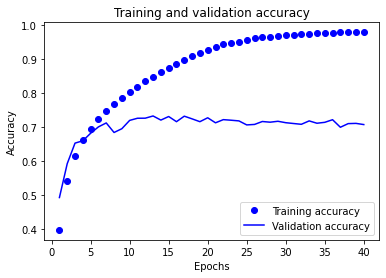

In [ ]:
plotter_accuracy(history)

This model already gives us a validation accuracy of around 72%, not bad for a first attempt.
We will use this model as a baseline for tweaking the hyperparameters of the architecture.
From the above plot we see that the model quickly begins overfitting.
Let us try to remedy this by adding a dropout layer and a data augmentation layer.
For the same reason, let us also reduce batch size.
Increasing the filter width seems pointless in such small images.
For the same small image reason, let us try to add padding in the convolutional layers.
Finally, let us reduce the learning rate, because I worry the dropout and reduced batch size might make the training accuracy jump around too much, instead of steadily increasing.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_images, partial_train_labels, epochs=40, batch_size=32,validation_data=(val_images, val_labels))

Epoch 1/40
1250/1250 [==============================] - 8s 5ms/step - loss: 1.3862 - accuracy: 0.5082 - val_loss: 1.4185 - val_accuracy: 0.4834
Epoch 2/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0078 - accuracy: 0.6476 - val_loss: 1.0426 - val_accuracy: 0.6409
Epoch 3/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8694 - accuracy: 0.6995 - val_loss: 0.8381 - val_accuracy: 0.7051
Epoch 4/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7829 - accuracy: 0.7319 - val_loss: 0.8515 - val_accuracy: 0.7072
Epoch 5/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7191 - accuracy: 0.7530 - val_loss: 0.7665 - val_accuracy: 0.7313
Epoch 6/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6644 - accuracy: 0.7727 - val_loss: 1.0565 - val_accuracy: 0.6660
Epoch 7/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6239 - accuracy: 0.7864 - val_loss: 0.8216 - val_accuracy:

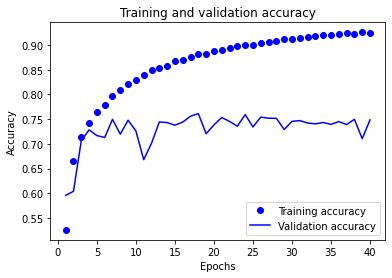

In [ ]:
plotter_accuracy(history)

This already boosts validation accuracy to 75%. The dense part of the network does not have a hidden layer.
Perhaps a non-linear transform of the features learnt from the convolutional part of the network might improve the network. Let us thus add a dense hidden layer with relu activation.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_images, partial_train_labels, epochs=40, batch_size=32,validation_data=(val_images, val_labels))

Epoch 1/40
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5215 - accuracy: 0.4518 - val_loss: 1.1905 - val_accuracy: 0.5749
Epoch 2/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1020 - accuracy: 0.6100 - val_loss: 0.9577 - val_accuracy: 0.6575
Epoch 3/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9369 - accuracy: 0.6730 - val_loss: 0.9376 - val_accuracy: 0.6669
Epoch 4/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8284 - accuracy: 0.7125 - val_loss: 0.8381 - val_accuracy: 0.7074
Epoch 5/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7470 - accuracy: 0.7397 - val_loss: 0.7572 - val_accuracy: 0.7355
Epoch 6/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6834 - accuracy: 0.7621 - val_loss: 0.8148 - val_accuracy: 0.7178
Epoch 7/40
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6220 - accuracy: 0.7844 - val_loss: 0.7288 - val_accuracy:

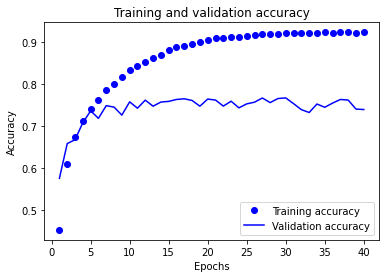

In [ ]:
plotter_accuracy(history)

This does not improve accuracy greatly, only a 1% gain is observed.
I tried batch normalization, but this gave terrible results and very slow training and is not included in the report.
As a final architecture, let us try residual connections.
The book states that residual connections help with the vanishing gradient problem.
I do not believe that models which only take minutes to train, would have such a vanishing gradient.
Another reason to use residual connections is that such networks tend to be better at learning identity transformations, than networks without these connections (Source: deeplearning.ai https://www.youtube.com/watch?v=RYth6EbBUqM).

In [ ]:
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_from_scratch",
        save_best_only=True,
        monitor="val_accuracy")
]
history = model.fit(partial_train_images, partial_train_labels, epochs=40, batch_size=32,validation_data=(val_images, val_labels),callbacks=callbacks)

Epoch 1/40
1250/1250 [==============================] - 14s 10ms/step - loss: 1.5607 - accuracy: 0.4438 - val_loss: 1.3305 - val_accuracy: 0.5304
Epoch 2/40
1250/1250 [==============================] - 13s 10ms/step - loss: 1.2345 - accuracy: 0.5601 - val_loss: 1.2138 - val_accuracy: 0.5799
Epoch 3/40
1250/1250 [==============================] - 12s 10ms/step - loss: 1.1057 - accuracy: 0.6113 - val_loss: 0.9754 - val_accuracy: 0.6610
Epoch 4/40
1250/1250 [==============================] - 12s 10ms/step - loss: 1.0240 - accuracy: 0.6396 - val_loss: 0.9276 - val_accuracy: 0.6792
Epoch 5/40
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9627 - accuracy: 0.6625 - val_loss: 0.8922 - val_accuracy: 0.6902
Epoch 6/40
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9255 - accuracy: 0.6778 - val_loss: 0.8008 - val_accuracy: 0.7212
Epoch 7/40
1250/1250 [==============================] - 13s 10ms/step - loss: 0.8883 - accuracy: 0.6900 - val_loss: 0.8271 -

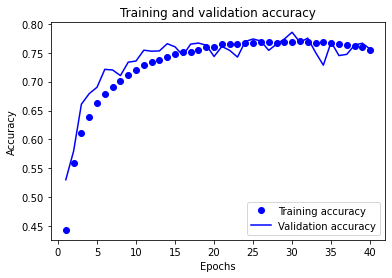

In [ ]:
plotter_accuracy(history)

This still boosts validation accuracy even closer to 80%. 
By fine tuning the architecture (in a space of possible architectures that only take minutes to train),
I thus increased the validation accuracy by over 5%.
This model will be further analyzed in Part 2.

### Question 1.2
We now try to improve on our network trained from scratch by using a pre-trained model.
We have to reload the dataset, since different preprocessing steps of the images are required.
Let us start with the architecture suggested in the textbook, but adapted for 10 classes instead of 2.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 32, 3))
conv_base.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images_prepro = keras.applications.vgg16.preprocess_input(train_images)
train_features = conv_base.predict(train_images_prepro)
test_images_prepro = keras.applications.vgg16.preprocess_input(test_images)
test_features = conv_base.predict(test_images_prepro)
train_features.shape

val_images = train_images[:10000]
val_features = train_features[:10000]
val_labels = train_labels[:10000]

partial_train_images = train_images[10000:]
partial_train_features = train_features[10000:]
partial_train_labels = train_labels[10000:]

In [ ]:
inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_features, partial_train_labels,epochs=40,batch_size=32,validation_data=(val_features, val_labels))

Epoch 1/40
1250/1250 [==============================] - 3s 2ms/step - loss: 4.4376 - accuracy: 0.4421 - val_loss: 1.4456 - val_accuracy: 0.5348
Epoch 2/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6341 - accuracy: 0.5256 - val_loss: 1.2024 - val_accuracy: 0.5903
Epoch 3/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.3901 - accuracy: 0.5651 - val_loss: 1.1372 - val_accuracy: 0.6171
Epoch 4/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.3310 - accuracy: 0.5819 - val_loss: 1.1331 - val_accuracy: 0.6169
Epoch 5/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2848 - accuracy: 0.5944 - val_loss: 1.0998 - val_accuracy: 0.6372
Epoch 6/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2551 - accuracy: 0.6047 - val_loss: 1.0916 - val_accuracy: 0.6404
Epoch 7/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2350 - accuracy: 0.6097 - val_loss: 1.1002 - val_accuracy:

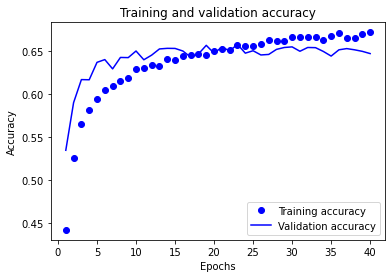

In [ ]:
plotter_accuracy(history)

This performs worse than our model trained from scratch.
We can try increasing the amount of units in the hidden dense layer,
but I doubt this will help significantly, since there are only a moderate amount of classes.

In [ ]:
inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_features, partial_train_labels,epochs=40,batch_size=32,validation_data=(val_features, val_labels))

Epoch 1/40
1250/1250 [==============================] - 3s 2ms/step - loss: 3.1079 - accuracy: 0.4851 - val_loss: 1.2498 - val_accuracy: 0.5784
Epoch 2/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5069 - accuracy: 0.5518 - val_loss: 1.1959 - val_accuracy: 0.5980
Epoch 3/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4637 - accuracy: 0.5704 - val_loss: 1.1957 - val_accuracy: 0.5978
Epoch 4/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4451 - accuracy: 0.5836 - val_loss: 1.2172 - val_accuracy: 0.6006
Epoch 5/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4416 - accuracy: 0.5907 - val_loss: 1.2076 - val_accuracy: 0.6032
Epoch 6/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4359 - accuracy: 0.5953 - val_loss: 1.2000 - val_accuracy: 0.6150
Epoch 7/40
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4480 - accuracy: 0.6006 - val_loss: 1.2094 - val_accuracy:

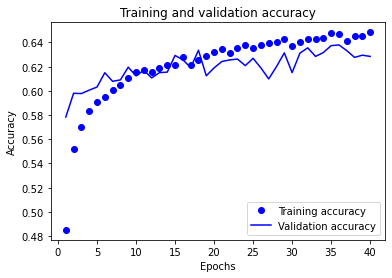

In [ ]:
plotter_accuracy(history)

What might help more, is adding an additional hidden layer, since the features coming from the pre-trained network might need a complicated non-linear transform to relate to our classes of interest.

In [ ]:
inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_features, partial_train_labels,epochs=40,batch_size=32,validation_data=(val_features, val_labels))

Epoch 1/40
1250/1250 [==============================] - 4s 3ms/step - loss: 2.1309 - accuracy: 0.4421 - val_loss: 1.1983 - val_accuracy: 0.5819
Epoch 2/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3332 - accuracy: 0.5484 - val_loss: 1.1561 - val_accuracy: 0.6047
Epoch 3/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2657 - accuracy: 0.5778 - val_loss: 1.1127 - val_accuracy: 0.6233
Epoch 4/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2370 - accuracy: 0.5875 - val_loss: 1.1170 - val_accuracy: 0.6245
Epoch 5/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2030 - accuracy: 0.5957 - val_loss: 1.0836 - val_accuracy: 0.6374
Epoch 6/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1913 - accuracy: 0.6052 - val_loss: 1.0520 - val_accuracy: 0.6428
Epoch 7/40
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1832 - accuracy: 0.6067 - val_loss: 1.0451 - val_accuracy:

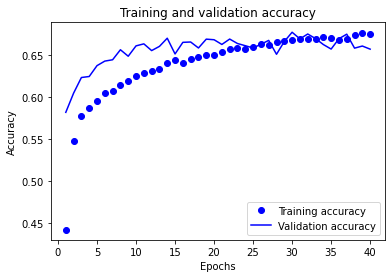

In [ ]:
plotter_accuracy(history)

Indeed, the validation accuracy now performs better, but still worse than our model trained from scratch.

### Question 1.3
Adding data augmentation to a network containing a pre-retrained convolutional part is less useful than adding it to a model trained from scratch.
Data augmentation helps for automated feature crafting for image classification on small data-sets,
but the pre-trained model is trained on a large data-set,
and should thus be able to return the same features for the augmented and unaugmented images.
Thus data augmentation would be be of limited help in training the dense part of the network.
On the other hand, it should not hurt validation accuracy to add data augmentation (only computational cost is increased).
To use augmented data in the method of Question 1.2, the entire augmented dataset has to be generated beforehand.
If we want to add the augmentation as a layer in the model, and generate augmented images while training, we can also do this using the following code.
These two methods should result in roughly the same validation accuracy.
I have also upscaled the images, since VGG16 is not meant to be used with small images.

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    input_shape=(64, 64, 3),
    include_top=False)
conv_base.trainable = False
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.UpSampling2D(size=2)(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_images, partial_train_labels,epochs=40,batch_size=32,validation_data=(val_images, val_labels))

Epoch 1/40
1250/1250 [==============================] - 12s 9ms/step - loss: 2.6768 - accuracy: 0.5055 - val_loss: 0.9221 - val_accuracy: 0.7253
Epoch 2/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4354 - accuracy: 0.5998 - val_loss: 0.9026 - val_accuracy: 0.7469
Epoch 3/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.3556 - accuracy: 0.6196 - val_loss: 0.9409 - val_accuracy: 0.7497
Epoch 4/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.3026 - accuracy: 0.6368 - val_loss: 0.9022 - val_accuracy: 0.7712
Epoch 5/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2798 - accuracy: 0.6463 - val_loss: 0.9437 - val_accuracy: 0.7640
Epoch 6/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2438 - accuracy: 0.6489 - val_loss: 0.9283 - val_accuracy: 0.7735
Epoch 7/40
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2195 - accuracy: 0.6620 - val_loss: 1.0261 - val_ac

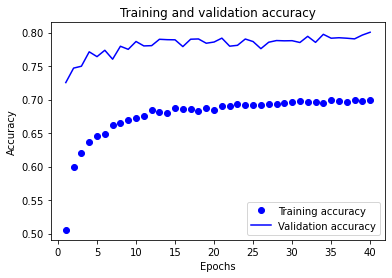

In [ ]:
plotter_accuracy(history)

We finally (slightly) breach 80% accuracy with this model.
I, however, cannot fully explain the large gap between training and validation accuracy.
This gap is in the opposite direction you would expect.
Possibly, this is because of dropout, but the effect is much more pronounced than in any other figure in this report.

### Question 1.4
Can we do better still by making the entire architecture trainable?
We further decrease the learning rate since we only want to fine-tune the VGG16 model parameters. The batch size is increased to reduce training time.

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    input_shape=(64, 64, 3),
    include_top=False)
conv_base.trainable = True
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.UpSampling2D(size=2)(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(partial_train_images, partial_train_labels,epochs=40,batch_size=512,validation_data=(val_images, val_labels))

Epoch 1/40
79/79 [==============================] - 15s 176ms/step - loss: 2.4817 - accuracy: 0.2128 - val_loss: 1.8075 - val_accuracy: 0.3493
Epoch 2/40
79/79 [==============================] - 14s 177ms/step - loss: 1.6124 - accuracy: 0.4294 - val_loss: 1.3489 - val_accuracy: 0.5694
Epoch 3/40
79/79 [==============================] - 14s 179ms/step - loss: 1.1820 - accuracy: 0.6034 - val_loss: 1.2216 - val_accuracy: 0.6211
Epoch 4/40
79/79 [==============================] - 14s 179ms/step - loss: 0.9329 - accuracy: 0.6898 - val_loss: 1.1131 - val_accuracy: 0.5986
Epoch 5/40
79/79 [==============================] - 14s 181ms/step - loss: 0.8033 - accuracy: 0.7311 - val_loss: 0.5933 - val_accuracy: 0.8113
Epoch 6/40
79/79 [==============================] - 17s 217ms/step - loss: 0.6761 - accuracy: 0.7742 - val_loss: 0.5718 - val_accuracy: 0.8089
Epoch 7/40
79/79 [==============================] - 14s 179ms/step - loss: 0.6228 - accuracy: 0.7919 - val_loss: 0.5198 - val_accuracy: 0.8235

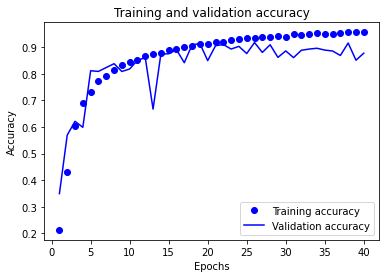

In [ ]:
plotter_accuracy(history)

This model is now moving towards 90% validation accuracy, and overfitting occurs very slowly. Now that we have chosen a final fine-tuning architecture, let us retrain this model on the entire training dataset for 20 epochs.

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    input_shape=(64, 64, 3),
    include_top=False)
conv_base.trainable = True
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.UpSampling2D(size=2)(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(train_images, train_labels,epochs=20,batch_size=512)
results = model.evaluate(test_images, test_labels)
results

Epoch 1/20
98/98 [==============================] - 17s 166ms/step - loss: 2.3514 - accuracy: 0.2215
Epoch 2/20
98/98 [==============================] - 16s 167ms/step - loss: 1.5079 - accuracy: 0.4789
Epoch 3/20
98/98 [==============================] - 16s 167ms/step - loss: 1.0764 - accuracy: 0.6415
Epoch 4/20
98/98 [==============================] - 19s 195ms/step - loss: 0.8158 - accuracy: 0.7296
Epoch 5/20
98/98 [==============================] - 17s 172ms/step - loss: 0.6983 - accuracy: 0.7682
Epoch 6/20
98/98 [==============================] - 16s 168ms/step - loss: 0.6071 - accuracy: 0.7978
Epoch 7/20
98/98 [==============================] - 17s 171ms/step - loss: 0.5431 - accuracy: 0.8195
Epoch 8/20
98/98 [==============================] - 17s 172ms/step - loss: 0.4864 - accuracy: 0.8362
Epoch 9/20
98/98 [==============================] - 17s 168ms/step - loss: 0.4409 - accuracy: 0.8520
Epoch 10/20
98/98 [==============================] - 17s 170ms/step - loss: 0.4070 - accura

[0.3169715404510498, 0.9129999876022339]

The performance on the test-set is an amazing 91%, not a bad result for only working on this problem for a weekend.
This clearly showcases the power of deep learning.
I doubt I could perform better myself on these blurry images!

## Part 2
Let us now investigate what features the best architecture in Part 1, Question 1 actually learns inside its hidden layers. We do this for the first 4 images in the test dataset.

cat


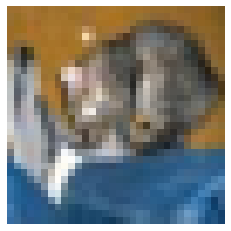

ship


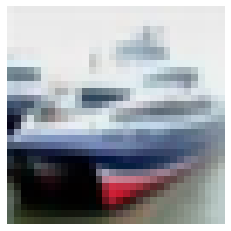

ship


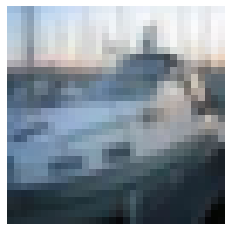

airplane


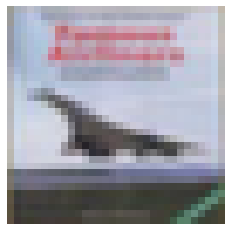

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
model = keras.models.load_model("./best_from_scratch")
labels = {0:"airplane",
  1:"automobile",
  2:"bird",
  3:"cat",
  4:"deer",
  5:"dog",
  6:"frog",
  7:"horse",
  8:"ship",
  9:"truck"}
for i in range(4):
  print(labels[test_labels[i][0]])
  plt.axis("off")
  plt.imshow(test_images[i])  
  plt.show()

We retrain the architecture for 20 epochs on the entire training dataset.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(train_images,train_labels, epochs=20, batch_size=32)
results = model.evaluate(test_images, test_labels)
results

Epoch 1/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.4988 - accuracy: 0.4637
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1775 - accuracy: 0.5804
Epoch 3/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0467 - accuracy: 0.6286
Epoch 4/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9733 - accuracy: 0.6596
Epoch 5/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9186 - accuracy: 0.6800
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8759 - accuracy: 0.6945
Epoch 7/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8479 - accuracy: 0.7049
Epoch 8/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8167 - accuracy: 0.7177
Epoch 9/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.7973 - accuracy: 0.7276
Epoch 10/20
1563/1563 [==============================] - 17s 11m

[0.6622790098190308, 0.7756999731063843]

In [ ]:
def extract_hidden_features_testset(i):
    print(labels[test_labels[i][0]])
    layer_outputs = []
    layer_names = []
    for layer in model.layers:
        if isinstance(layer, (layers.Conv2D)):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)
    activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(test_images[i:i+1])
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(((size + 1) * n_cols - 1,
                                 images_per_row * (size + 1) - 1))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                channel_image = layer_activation[0, :, :, channel_index].copy()
                if channel_image.sum() != 0:
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                else:
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[
                    col * (size + 1): (col + 1) * size + col,
                    row * (size + 1) : (row + 1) * size + row] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap="viridis")

cat


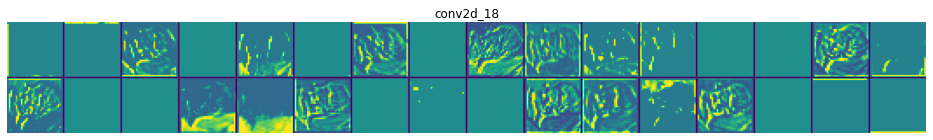

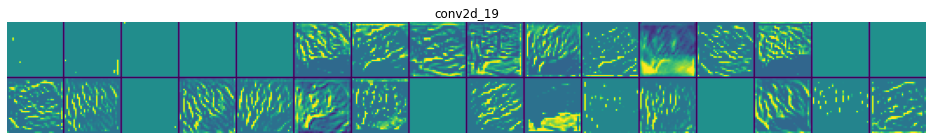

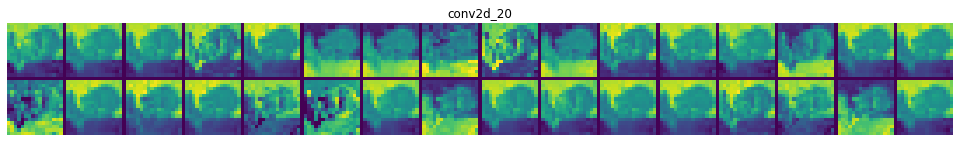

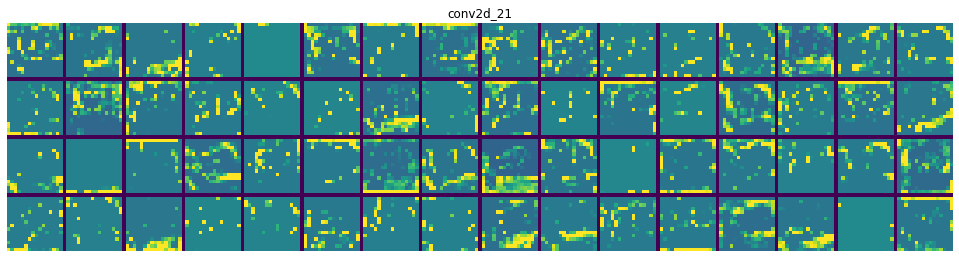

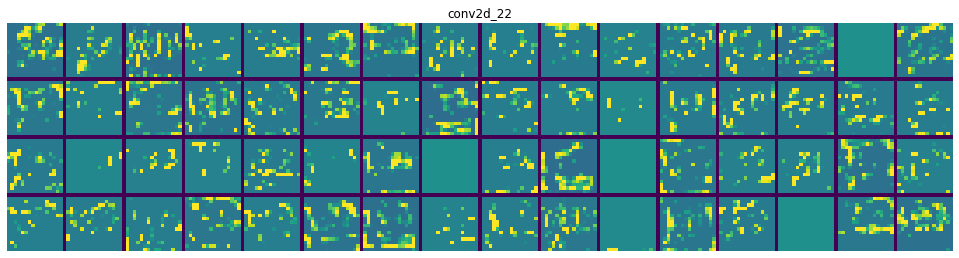

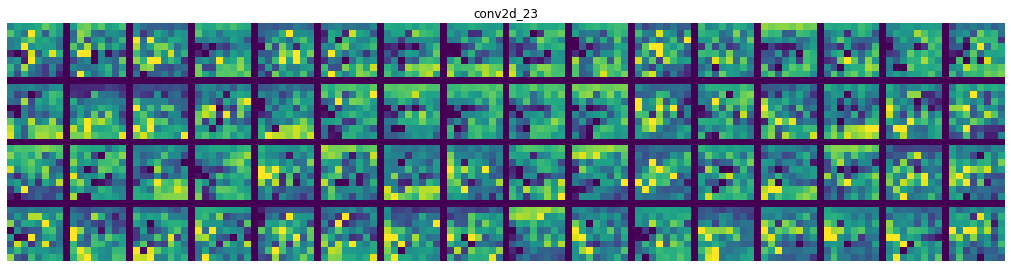

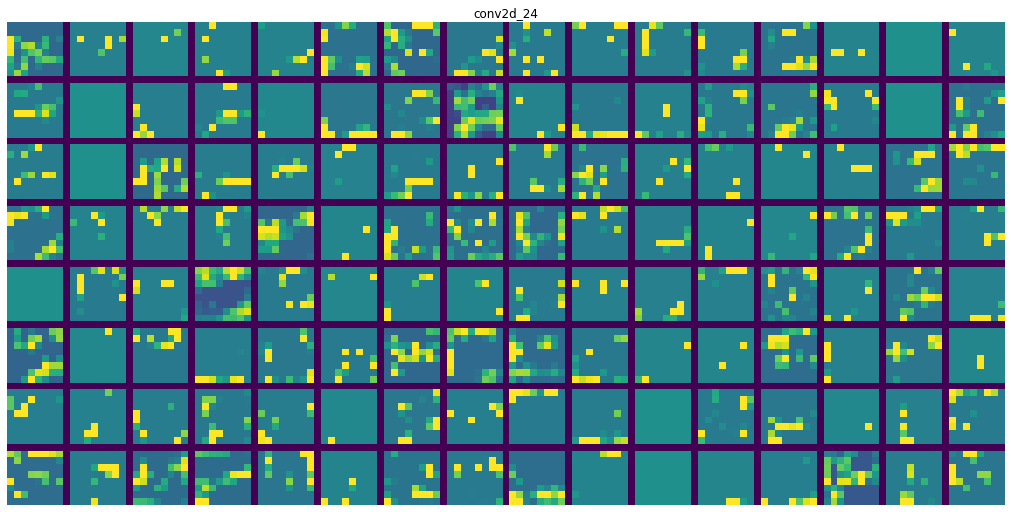

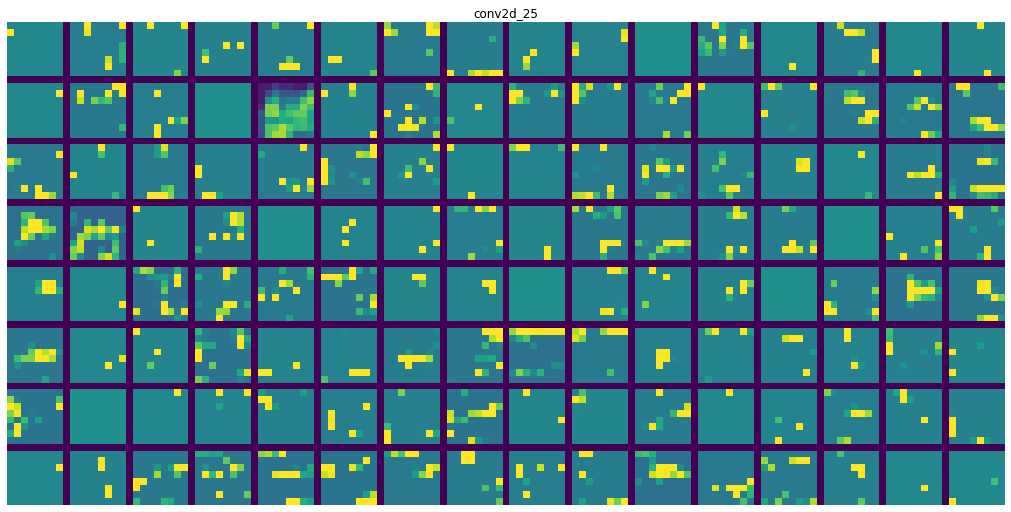

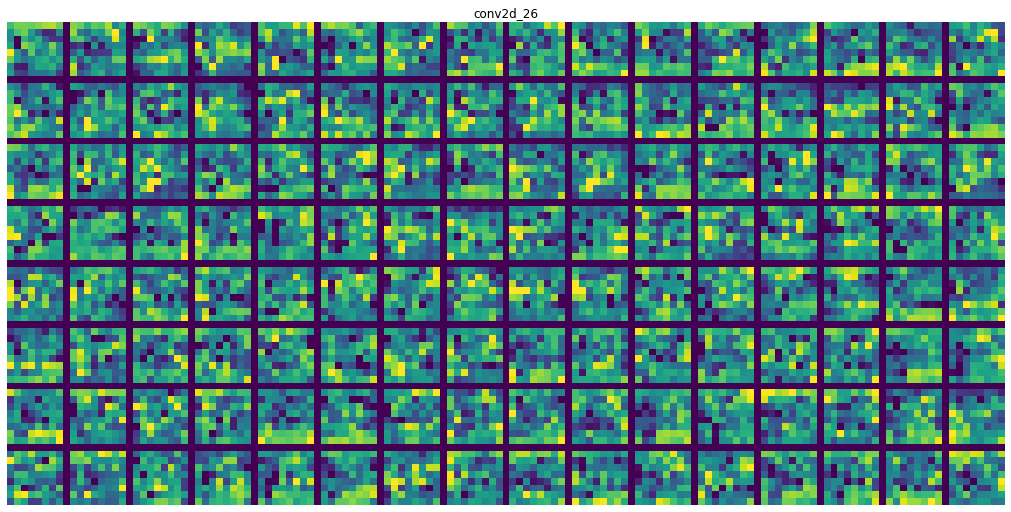

In [ ]:
extract_hidden_features_testset(0)

ship


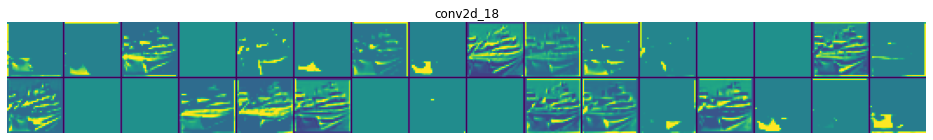

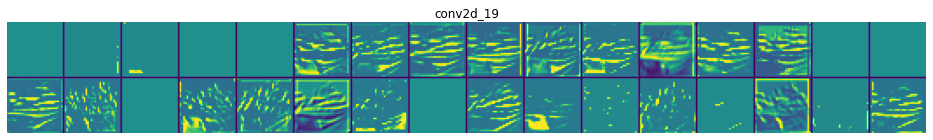

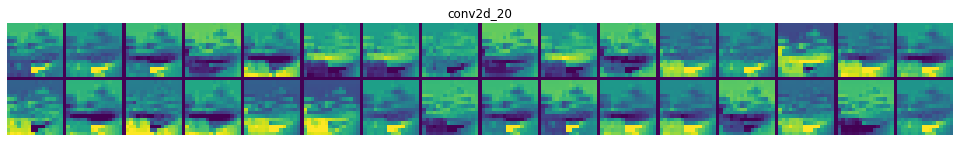

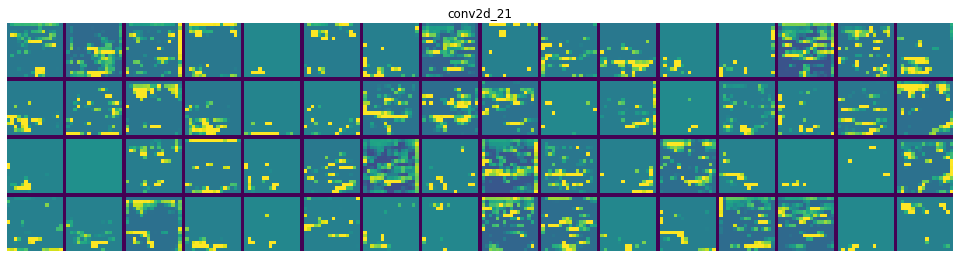

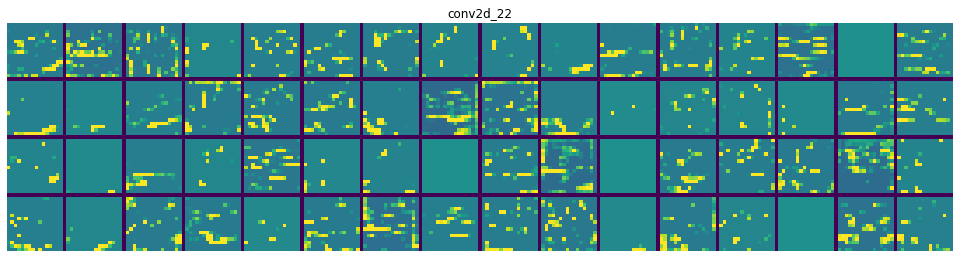

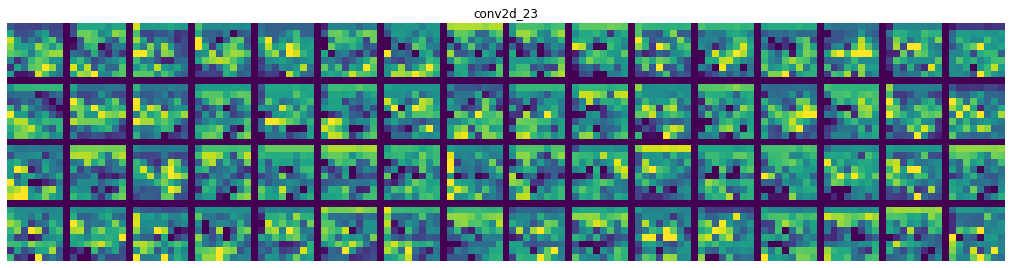

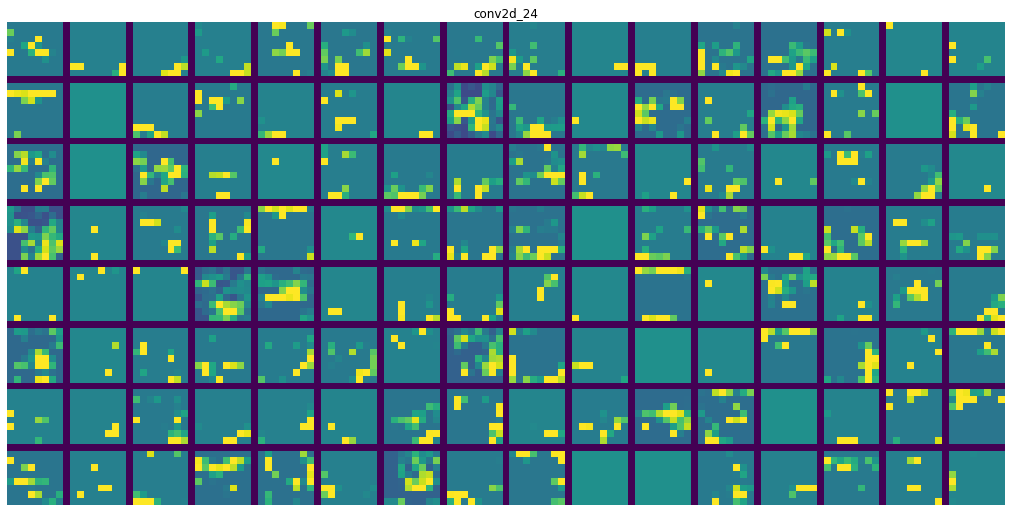

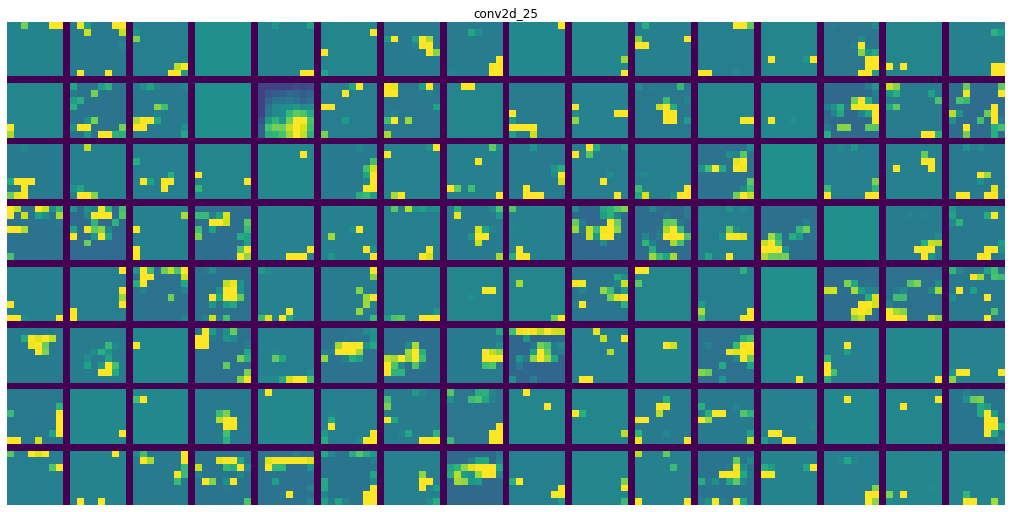

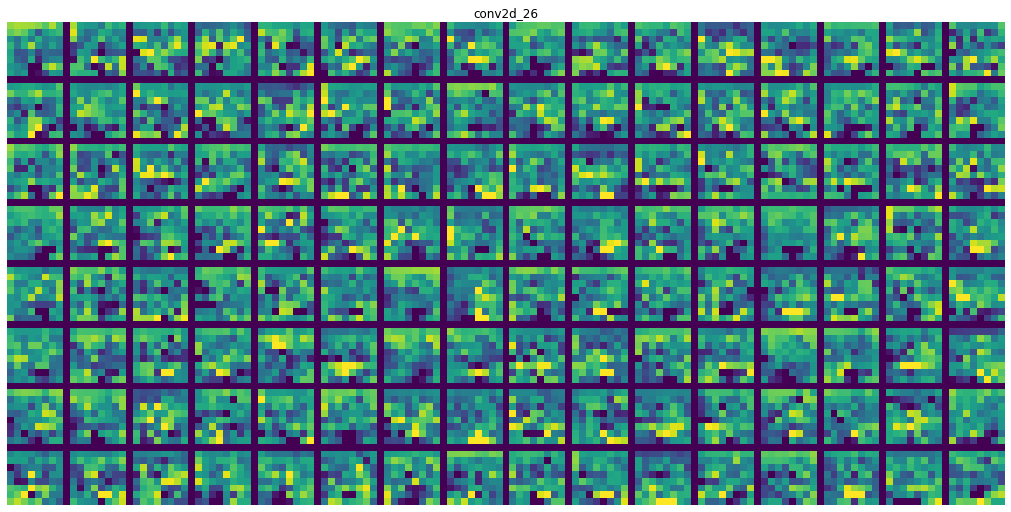

In [ ]:
extract_hidden_features_testset(1)

ship


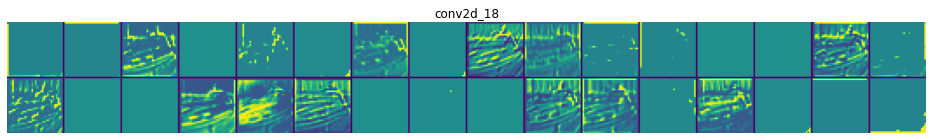

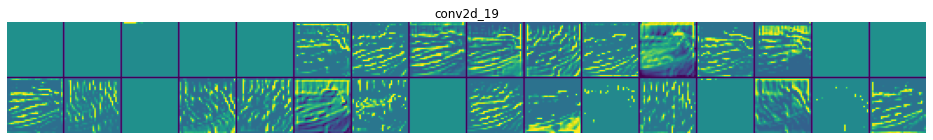

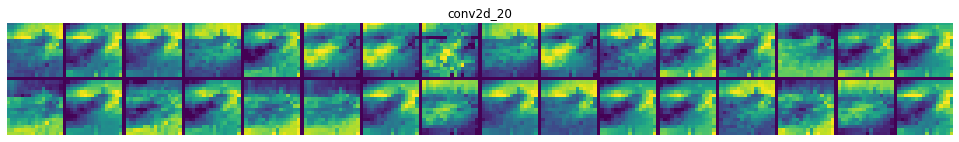

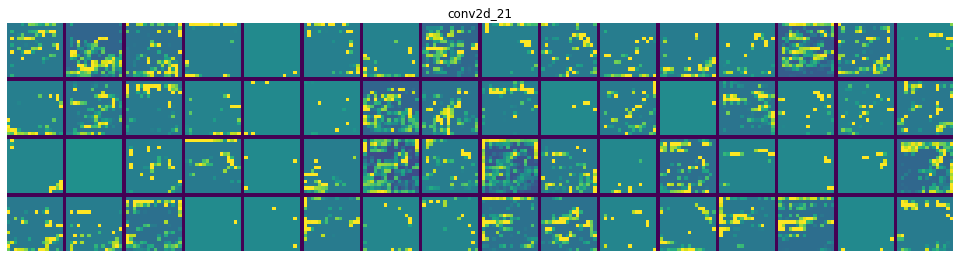

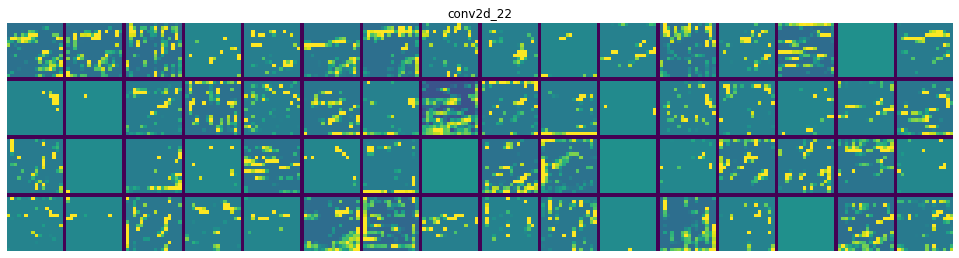

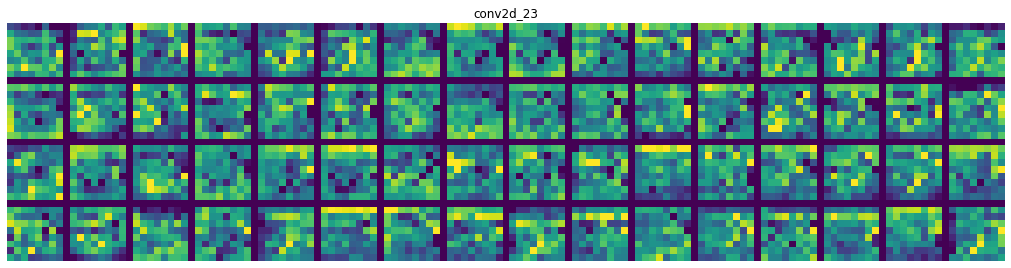

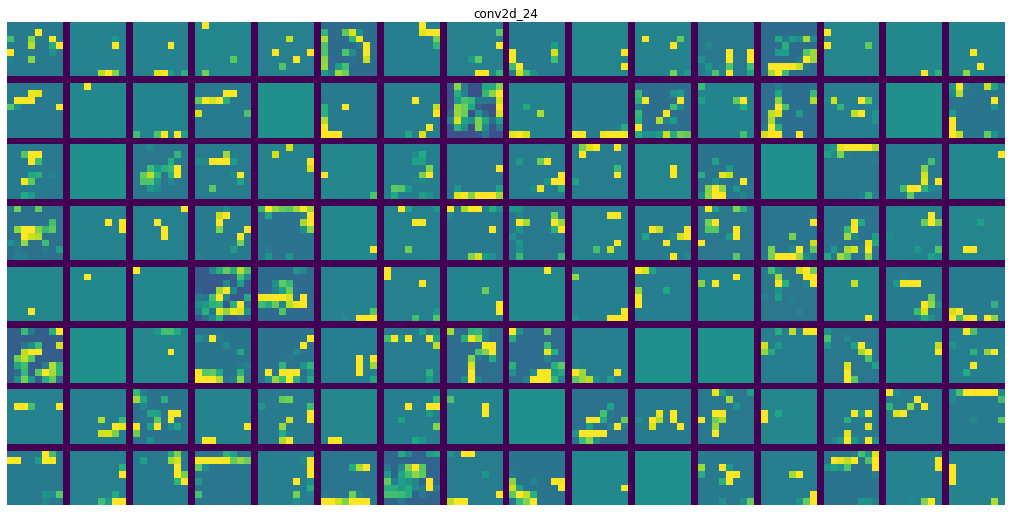

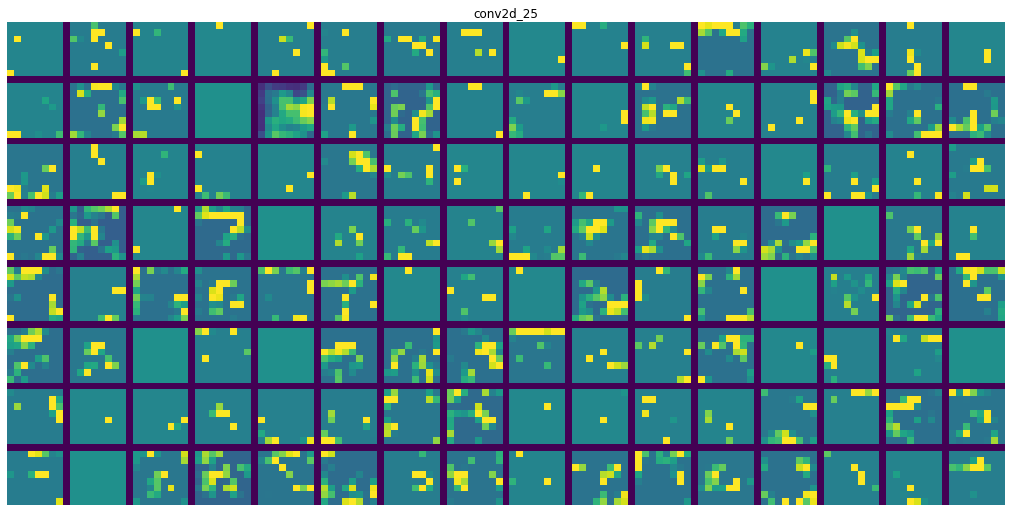

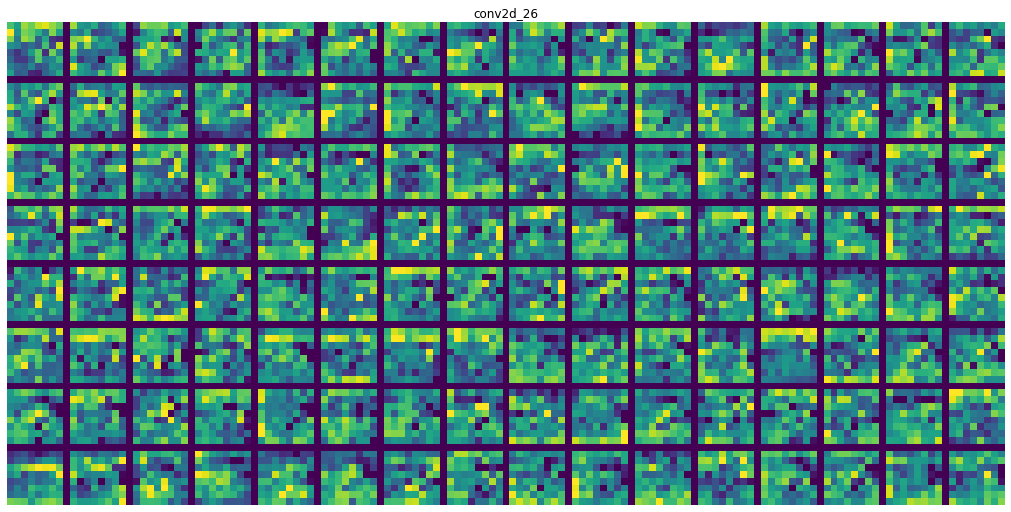

In [ ]:
extract_hidden_features_testset(2)

airplane


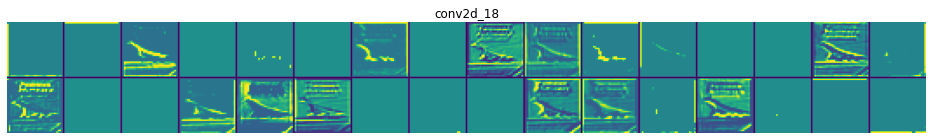

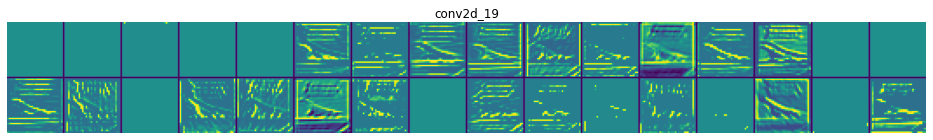

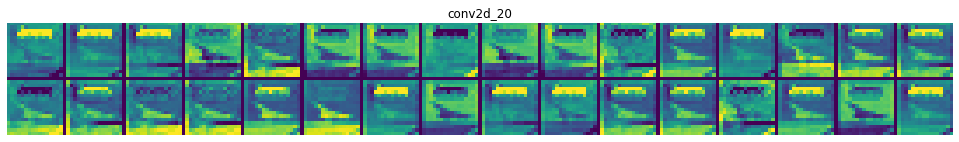

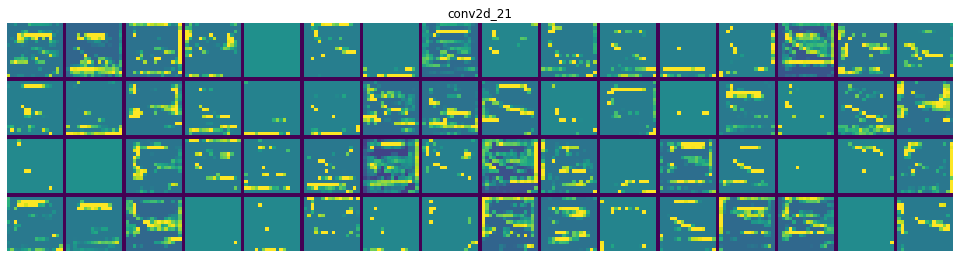

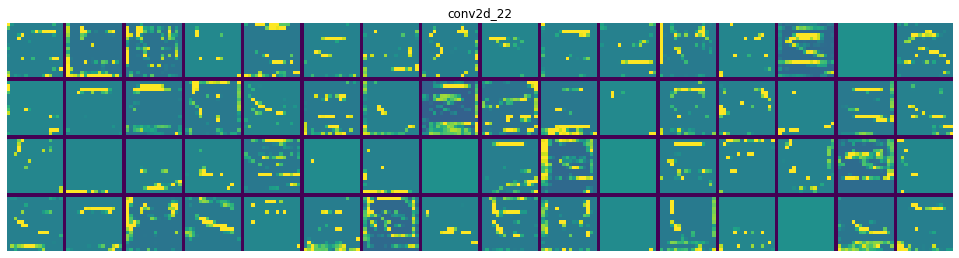

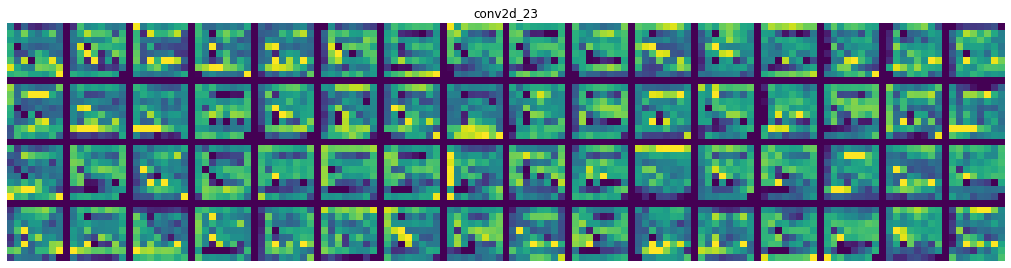

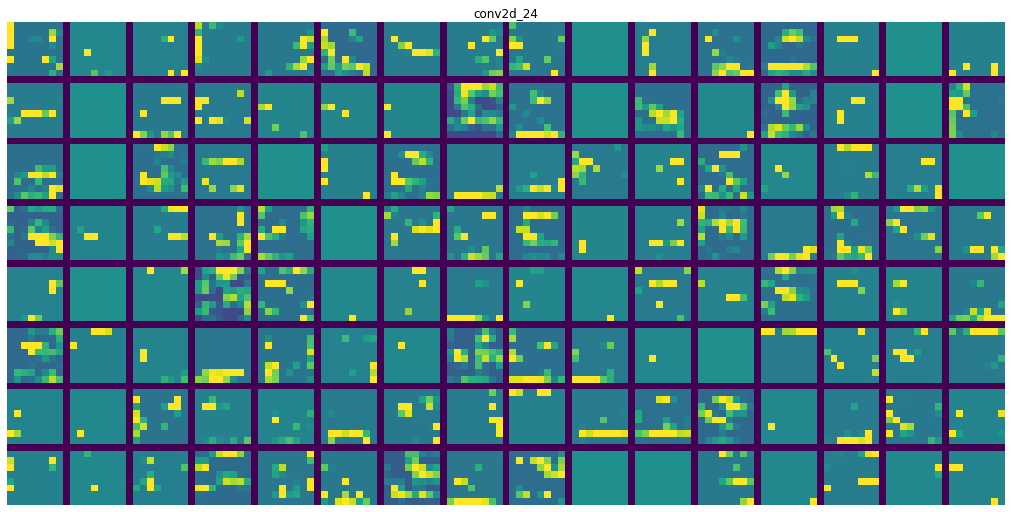

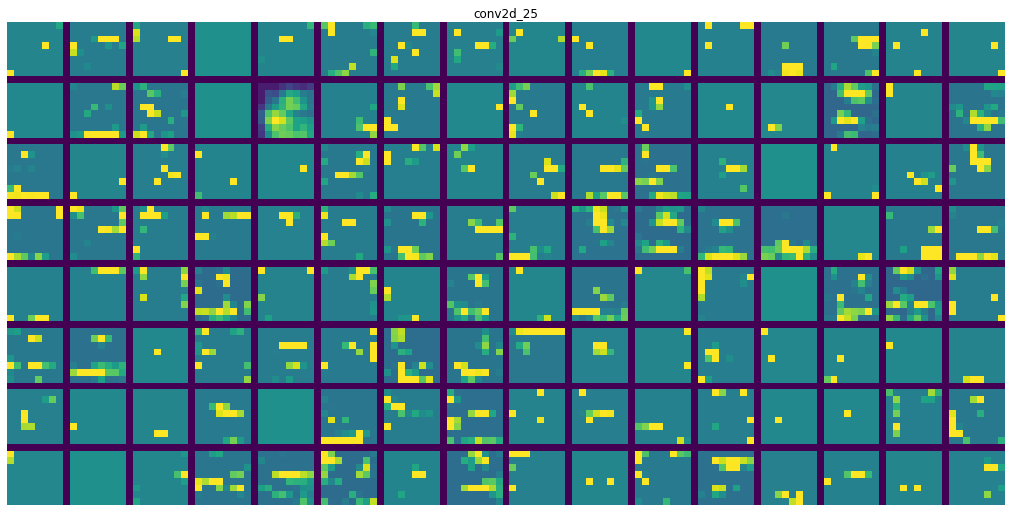

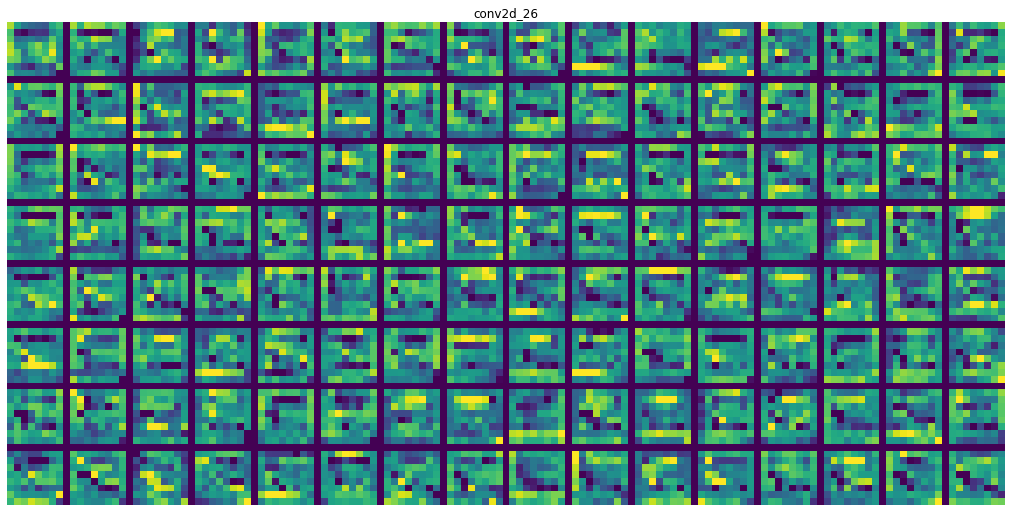

In [ ]:
extract_hidden_features_testset(3)

Highly negative activations are blue.
Small activations absolute value wise are green.
Highly positive activations are yellow.
We see that every third subfigure has lively patterns, while the other two are almost fully green.
This is expected given that every third subfigure has the residual connections.
When the other two layers are mostly zero, the identity function is performed in those layers of the network.
The network then is equivalent to a shallower network without skipping connections, which is a good baseline behaviour. 
If something very important is going on for certain classes in certain areas of the figure (or filtered figure) than the network can deviate from the identity function.
We also see that the first layer performs edge detection, for example the edge between the sea and the sky for boats.
It is difficult for me to recognize any abstract higher level features, such as a cat's eye in the later layers. 
Performing dimension reduction on the last convolutional layer (for all test images) also does not lead to very clear clusters. Our model trained from scratch is not capable of extracting clear features, which is why it is not able to achieve 90% test accuracy, like VGG16.

In [ ]:
from sklearn.manifold import TSNE
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
layer_output = layer_outputs[-1]
layer_name = layer_names[-1]
activation_model = keras.Model(inputs=model.input, outputs=layer_output)
activations = activation_model.predict(test_images)
intermediates = layers.Flatten()(activations)
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

C:\Users\arno\anaconda3\envs\test1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arno\anaconda3\envs\test1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


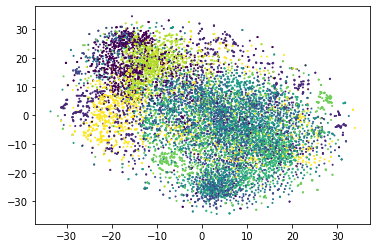

In [ ]:
plt.scatter(intermediates_tsne[:,0],intermediates_tsne[:,1], c=test_labels,s=1)
plt.show()